In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, random_split
from torch.autograd import grad
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
import torch.nn.functional as F
import numpy as np 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

In [4]:
device

device(type='mps')

In [5]:
class MinMaxConstraint:
    """Custom min-max constraint applied manually during forward."""
    def __init__(self, min_value=0.0, max_value=10.0):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):
        return torch.clamp(w, self.min_value, self.max_value)


def nmodeproduct(x, w, mode):
    """
    n-mode product for 3D tensors.
    x: (N, H, W)
    mode = 1 → w: (H, h)
    mode = 2 → w: (W, w)
    Output: (N, h, W) or (N, H, w)
    """
    if mode == 2:
        # mode-2: multiply along the last dimension
        return torch.matmul(x, w)  # (N, H, W) x (W, w) → (N, H, w)
    else:
        # mode-1: multiply along the second dimension
        x = x.transpose(1, 2)      # (N, W, H)
        x = torch.matmul(x, w)     # (N, W, h)
        x = x.transpose(1, 2)      # (N, h, W)
        return x


class TABL(nn.Module):
    """
    Temporal Attention Augmented Bilinear Layer
    (PyTorch version of Tran et al., 2017)
    """
    def __init__(self, input_dim, output_dim):
        """
        input_dim : tuple (D1, D2)
        output_dim : tuple (d1, d2)
        """
        super(TABL, self).__init__()
        D1, D2 = input_dim
        d1, d2 = output_dim

        # Projection matrices
        self.W1 = nn.Parameter(torch.empty(D1, d1))
        self.W2 = nn.Parameter(torch.empty(D2, d2))
        self.W = nn.Parameter(torch.full((D2, D2), 1.0 / D2))

        # Scalar attention blending coefficient
        self.alpha = nn.Parameter(torch.tensor([0.5]))

        # Bias
        self.bias = nn.Parameter(torch.zeros(1, d1, d2))

        # Initialization
        nn.init.kaiming_uniform_(self.W1, a=5**0.5)
        nn.init.kaiming_uniform_(self.W2, a=5**0.5)

        self.alpha_constraint = MinMaxConstraint(0.0, 1.0)
        self.D2 = D2
        self.output_dim = output_dim

    def forward(self, x):
        """
        x: (N, D1, D2)
        """
        # First mode projection: N x D1 x D2 → N x d1 x D2
        x_proj = nmodeproduct(x, self.W1, 1)

        # Enforce constant (1/D2) on diagonal
        eye = torch.eye(self.D2, device=x.device)
        W = self.W - self.W * eye + eye / self.D2

        # Attention map
        att = torch.matmul(x_proj, W)          # N x d1 x D2
        att = F.softmax(att, dim=-1)

        # Apply attention
        alpha = self.alpha_constraint(self.alpha)
        x_att = alpha * (x_proj * att) + (1 - alpha) * x_proj

        # Second mode projection
        out = nmodeproduct(x_att, self.W2, 2)

        # Add bias
        out = out + self.bias

        # Optional squeeze if second dim = 1
        if self.output_dim[1] == 1:
            out = out.squeeze(-1)

        return out

In [6]:
class TABLClassifier(nn.Module):
    def __init__(
        self,
        s_input_dim,          # (D, T) e.g. (16, 50)
        tabl_hidden_dims,     # [(d1, t1), (d2, t2)]
        hidden_dim,           # MLP hidden dim
        cond_dim=3,           # <-- dimension of second input (1x3)
        num_classes=3
    ):
        super().__init__()

        # --- State path (TABL layers) ---
        self.tabl1 = TABL(s_input_dim, tabl_hidden_dims[0])
        self.tabl2 = TABL(tabl_hidden_dims[0], tabl_hidden_dims[1])

        # --- Dimensions ---
        tabl_flat_dim = tabl_hidden_dims[1][0] * tabl_hidden_dims[1][1]
        fusion_dim = tabl_flat_dim + cond_dim

        # --- MLP classifier ---
        self.fc1 = nn.Linear(fusion_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, num_classes)

        self.relu = nn.ReLU()

    def forward(self, s, c):
        """
        s: (B, D, T)     -> TABL input
        c: (B, 3)        -> conditional vector

        returns:
            logits: (B, num_classes)
        """

        # --- TABL feature extraction ---
        s = self.tabl1(s)
        s = self.tabl2(s)

        # --- Flatten TABL output ---
        s = s.view(s.size(0), -1)   # (B, tabl_flat_dim)

        # --- Concatenate conditional input ---
        x = torch.cat([s, c], dim=1)  # (B, tabl_flat_dim + 3)

        # --- MLP classifier ---
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        logits = self.fc_out(x)

        return logits

In [7]:
z_dim = 6
s_input_dim = (16,50) # make it 16 x 50
hidden_dim = 128
tabl_hidden_dims = [(32,24), (64,1)] # change to 32 x 24, 64x1
num_epochs = 2000
batch_size = 512
learning_rate = 5e-4

In [8]:
# Initialize models
model = TABLClassifier(
    s_input_dim,
    tabl_hidden_dims,
    hidden_dim,
).to(device)

# Optimizers
opt_C = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.9))

In [9]:
_s_w0 = pd.read_parquet('/Users/navindupalliyaguruge/Documents/GitHub/Thesis_extension/intc_history').reset_index(drop=True)
_real_x_w0 = pd.read_parquet('/Users/navindupalliyaguruge/Documents/GitHub/Thesis_extension/intc_target').reset_index(drop=True)

In [10]:
_s = _s_w0.fillna(0)
real_x = _real_x_w0.fillna(0)

In [11]:
def drop_unwanted_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Remove all TIME_CREATED columns, PRICE columns, MID_PRICE columns, and ROW_IDX column.
    """
    cols_to_drop = [
        col for col in df.columns
        if col.startswith("TIME_CREATED")
        or "_PRICE" in col
        or col.startswith("MID_PRICE")
        or col == "STEP"
    ]
    return df.drop(columns=cols_to_drop)

In [12]:
filter_s = drop_unwanted_columns(_s)
filter_real_x = drop_unwanted_columns(real_x)

In [13]:
filter_s

,BID_8_QUANTITY,BID_7_QUANTITY,BID_6_QUANTITY,BID_5_QUANTITY,BID_4_QUANTITY,BID_3_QUANTITY,BID_2_QUANTITY,BID_1_QUANTITY,ASK_1_QUANTITY,ASK_2_QUANTITY,ASK_3_QUANTITY,ASK_4_QUANTITY,ASK_5_QUANTITY,ASK_6_QUANTITY,ASK_7_QUANTITY,ASK_8_QUANTITY,ROW_IDX
0,-1.767767,-2.117929,-2.256657,-1.787107,-2.048933,-2.220220,-2.551225,-2.263846,1.762987,1.950641,2.367752,4.591024,1.391941,1.738534,2.300815,1.984313,151
1,-1.767767,-2.117929,-2.256657,-1.804508,-2.048933,-2.220220,-2.551225,-2.263846,1.780625,1.950641,2.367752,4.591024,1.369306,1.738534,2.300815,1.984313,151
2,-1.767767,-2.117929,-2.256657,-1.804508,-2.048933,-2.220220,-2.551225,-2.263846,1.762987,1.950641,2.367752,4.591024,1.369306,1.738534,2.300815,1.984313,151
3,-1.767767,-2.117929,-2.256657,-1.804508,-2.048933,-2.220220,-2.551225,-2.165063,1.762987,1.950641,2.367752,4.591024,1.369306,1.738534,2.300815,1.984313,151
4,-1.767767,-2.103123,-2.256657,-1.821744,-2.048933,-2.220220,-2.551225,-1.854050,1.815386,1.950641,2.354517,4.597826,1.369306,1.738534,2.300815,1.984313,151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2399995,-3.230712,-3.000000,-3.557562,-3.376574,-3.888042,-4.129013,-3.185514,-1.135507,3.759405,3.746165,3.779137,3.849513,3.284528,3.338319,3.076321,2.996665,2814577
2399996,-3.230712,-3.000000,-3.557562,-3.376574,-3.888042,-4.129013,-3.185514,-1.135507,3.833487,3.746165,3.779137,3.849513,3.284528,3.338319,3.076321,2.996665,2814577
2399997,-3.230712,-3.000000,-3.557562,-3.376574,-3.888042,-4.144122,-3.185514,-1.135507,3.833487,3.746165,3.779137,3.849513,3.284528,3.338319,3.076321,2.996665,2814577
2399998,-3.230712,-3.000000,-3.557562,-3.376574,-3.888042,-4.144122,-3.185514,-1.135507,3.759405,3.746165,3.779137,3.849513,3.284528,3.338319,3.076321,2.996665,2814577


In [14]:
filter_real_x = filter_real_x.iloc[:, [0, -1]]

In [15]:
filter_real_x

,row_id,PRICE_TREND_10
0,151,up
1,164,up
2,206,up
3,212,up
4,237,same
...,...,...
47995,2814228,same
47996,2814462,same
47997,2814530,same
47998,2814574,same


In [16]:
def process_condition_df(
    df,
    num_classes=3,
    group_fracs=(0.33, 0.33, 0.34),
    random_state=42
):
    """
    Args:
        df: DataFrame with
            col 0 -> index / row id
            col 1 -> categorical condition label
        num_classes: number of classes (default=3)
        group_fracs: fractions for the 3 groups
        random_state: reproducibility

    Returns:
        out_df: DataFrame with
            ['row_id', 'label', 'c0', 'c1', 'c2', 'group']
        label_to_idx: dict mapping label -> class index
    """

    df = df.copy()
    df.columns = ["row_id", "PRICE_TREND_10"]

    # --- Encode labels to integers ---
    labels = df["PRICE_TREND_10"].astype(str).unique()
    assert len(labels) == num_classes, "Number of unique labels must be 3"

    label_to_idx = {lab: i for i, lab in enumerate(sorted(labels))}
    idx_to_label = {v: k for k, v in label_to_idx.items()}

    y = df["PRICE_TREND_10"].map(label_to_idx).values

    # --- One-hot encode ---
    one_hot = np.eye(num_classes)[y]   # (N, 3)

    # --- Split into groups ---
    rng = np.random.default_rng(random_state)
    indices = np.arange(len(df))
    rng.shuffle(indices)

    n1 = int(group_fracs[0] * len(df))
    n2 = int(group_fracs[1] * len(df))

    g1 = indices[:n1]
    g2 = indices[n1:n1+n2]
    g3 = indices[n1+n2:]

    groups = np.zeros(len(df), dtype=int)
    groups[g1] = 1
    groups[g2] = 2
    groups[g3] = 3

    # --- Apply transformations ---

    # Group 1: change to a different class
    for i in g1:
        old = y[i]
        new = rng.choice([j for j in range(num_classes) if j != old])
        one_hot[i] = np.eye(num_classes)[new]

    # Group 2: replace with uniform distribution
    one_hot[g2] = np.full((len(g2), num_classes), 1.0 / num_classes)

    # Group 3: no change

    # --- Build output DataFrame ---
    out_df = pd.DataFrame(
        {
            "row_id": df["row_id"].values,
            "label": df["PRICE_TREND_10"].values,
            "c0": one_hot[:, 0],
            "c1": one_hot[:, 1],
            "c2": one_hot[:, 2],
            "group": groups,
        }
    )

    return out_df, label_to_idx

In [17]:
cols_s = filter_s.columns.difference(['ROW_IDX'])
max_s = filter_s[cols_s].abs().to_numpy().max()

In [18]:
# Make copies so original data isn't changed
s_scaled = filter_s.copy()

# Scale only non-ROW_IDX columns
s_scaled.loc[:, cols_s] = (
    s_scaled.loc[:, cols_s].astype(np.float32) / np.float32(max_s)
)

/var/folders/m1/dlbfvgxx4tjdfn43gl2qqmk80000gn/T/ipykernel_3879/92782711.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.20234669 0.20234669 0.20234669 ... 0.16966503 0.16966503 0.16966503]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  s_scaled.loc[:, cols_s] = (
/var/folders/m1/dlbfvgxx4tjdfn43gl2qqmk80000gn/T/ipykernel_3879/92782711.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.06134899 0.06035138 0.06035138 ... 0.14476365 0.14476365 0.14476365]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  s_scaled.loc[:, cols_s] = (
/var/folders/m1/dlbfvgxx4tjdfn43gl2qqmk80000gn/T/ipykernel_3879/92782711.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.07662486 0.07662486 0.

In [19]:
cond_df,_ = process_condition_df(filter_real_x)

In [20]:
cond_df

,row_id,label,c0,c1,c2,group
0,151,up,0.000000,0.000000,1.000000,3
1,164,up,1.000000,0.000000,0.000000,1
2,206,up,1.000000,0.000000,0.000000,1
3,212,up,1.000000,0.000000,0.000000,1
4,237,same,0.333333,0.333333,0.333333,2
...,...,...,...,...,...,...
47995,2814228,same,0.000000,1.000000,0.000000,3
47996,2814462,same,0.000000,1.000000,0.000000,3
47997,2814530,same,0.000000,1.000000,0.000000,3
47998,2814574,same,0.000000,1.000000,0.000000,3


In [21]:
def encode_labels(series):
    labels = sorted(series.unique())
    label_to_idx = {l: i for i, l in enumerate(labels)}
    idx_to_label = {i: l for l, i in label_to_idx.items()}
    encoded = series.map(label_to_idx).values
    return encoded, label_to_idx, idx_to_label

In [22]:
class GANTableDataset(Dataset):
    def __init__(self, cond_df, side_df, seq_len=50):
        """
        cond_df: output of process_condition_df()
                 columns: row_id, label, c0, c1, c2, group
        side_df: DataFrame containing s matrices (with 'ROW_IDX')
        """

        if "row_id" not in cond_df.columns:
            raise ValueError("cond_df must contain 'row_id'")

        if "ROW_IDX" not in side_df.columns:
            raise ValueError("side_df must contain 'ROW_IDX'")

        # --- Encode true labels (for supervision) ---
        encoded_labels, self.label_to_idx, self.idx_to_label = encode_labels(cond_df["label"])

        # --- Conditional vectors ---
        c_vectors = cond_df[["c0", "c1", "c2"]].values.astype(np.float32)

        # --- Row IDs ---
        x_row_ids = cond_df["row_id"].values

        # --- Side data ---
        feature_cols_s = [c for c in side_df.columns if c != "ROW_IDX"]
        s_values = side_df[feature_cols_s].values.astype(np.float32)
        s_row_ids = side_df["ROW_IDX"].values

        unique_rows = np.unique(s_row_ids)

        s_blocks = []
        y_labels = []
        c_blocks = []

        for rid in unique_rows:
            block = s_values[s_row_ids == rid]

            if block.shape[0] >= seq_len:
                block = block[-seq_len:, :]
                idx = np.where(x_row_ids == rid)[0]

                if len(idx) == 0:
                    continue

                s_blocks.append(block)
                y_labels.append(encoded_labels[idx[0]])
                c_blocks.append(c_vectors[idx[0]])

        if not s_blocks:
            raise ValueError("No valid s_blocks found")

        # --- Format TABL input ---
        s_blocks = np.stack(s_blocks)                 # (N, seq_len, D)
        s_blocks = np.transpose(s_blocks, (0, 2, 1))  # (N, D, seq_len)

        self.s = torch.tensor(s_blocks, dtype=torch.float32)
        self.y = torch.tensor(y_labels, dtype=torch.long)
        self.c = torch.tensor(c_blocks, dtype=torch.float32)

        assert len(self.s) == len(self.y) == len(self.c)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.s[idx], self.c[idx], self.y[idx]

In [23]:
dataset = GANTableDataset(cond_df[:36000], s_scaled[:36000*50])

/var/folders/m1/dlbfvgxx4tjdfn43gl2qqmk80000gn/T/ipykernel_3879/1798537801.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  self.c = torch.tensor(c_blocks, dtype=torch.float32)


In [24]:
val_ratio = 0.2 
n_total = len(dataset)
n_val = int(val_ratio * n_total)
n_train = n_total - n_val

In [25]:
train_dataset, val_dataset = random_split(
    dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256, shuffle=False)

In [26]:
# Optional: Learning rate schedulers
scheduler_C = optim.lr_scheduler.StepLR(opt_C, step_size=10, gamma=0.95)

In [27]:
D, T = dataset.s.shape[1], dataset.s.shape[2]
NUM_CLASSES = len(dataset.label_to_idx)

criterion = torch.nn.CrossEntropyLoss()

In [28]:
from sklearn.metrics import f1_score

def evaluate_f1(model, dataloader, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for s, c, y in dataloader:
            s = s.to(device)
            c = c.to(device)
            y = y.to(device)

            logits = model(s, c)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return f1_score(all_targets, all_preds, average="macro")

In [29]:
patience = 200
min_delta = 1e-3

best_val_f1 = -float("inf")
epochs_no_improve = 0
best_state = None

In [30]:
from sklearn.metrics import f1_score
import copy

history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "train_f1": [],
    "val_f1": []
}

best_val_f1 = -1
best_state = None

for epoch in range(num_epochs):

    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    all_train_preds = []
    all_train_targets = []

    for s, c, y in train_loader:
        s = s.to(device)
        c = c.to(device)
        y = y.to(device)

        opt_C.zero_grad()

        logits = model(s, c)
        loss = criterion(logits, y)

        loss.backward()
        opt_C.step()

        total_loss += loss.item() * s.size(0)

        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        all_train_preds.append(preds.detach().cpu())
        all_train_targets.append(y.detach().cpu())

    # --- Train metrics ---
    train_loss = total_loss / total
    train_acc = correct / total

    all_train_preds = torch.cat(all_train_preds).numpy()
    all_train_targets = torch.cat(all_train_targets).numpy()
    train_f1 = f1_score(all_train_targets, all_train_preds, average="macro")

    # --- Validation F1 ---
    val_f1 = evaluate_f1(model, val_loader, device)

    # --- Save best model ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = copy.deepcopy(model.state_dict())

    # --- Log history ---
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)

    # --- Print every 10 epochs ---
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        print(
            f"Epoch {epoch:03d} | "
            f"Loss: {train_loss:.4f} | "
            f"Acc: {train_acc:.4f} | "
            f"Train F1: {train_f1:.4f} | "
            f"Val F1: {val_f1:.4f}"
        )

Epoch 000 | Loss: 0.7930 | Acc: 0.7207 | Train F1: 0.2911 | Val F1: 0.2812
Epoch 010 | Loss: 0.6840 | Acc: 0.7330 | Train F1: 0.3221 | Val F1: 0.3254
Epoch 020 | Loss: 0.6738 | Acc: 0.7363 | Train F1: 0.3777 | Val F1: 0.3312
Epoch 030 | Loss: 0.6679 | Acc: 0.7389 | Train F1: 0.3986 | Val F1: 0.4288
Epoch 040 | Loss: 0.6626 | Acc: 0.7411 | Train F1: 0.4092 | Val F1: 0.4425
Epoch 050 | Loss: 0.6574 | Acc: 0.7432 | Train F1: 0.4199 | Val F1: 0.4368
Epoch 060 | Loss: 0.6542 | Acc: 0.7445 | Train F1: 0.4249 | Val F1: 0.4482
Epoch 070 | Loss: 0.6508 | Acc: 0.7458 | Train F1: 0.4308 | Val F1: 0.4283
Epoch 080 | Loss: 0.6470 | Acc: 0.7473 | Train F1: 0.4343 | Val F1: 0.4052
Epoch 090 | Loss: 0.6428 | Acc: 0.7478 | Train F1: 0.4384 | Val F1: 0.4119
Epoch 100 | Loss: 0.6376 | Acc: 0.7491 | Train F1: 0.4441 | Val F1: 0.4383
Epoch 110 | Loss: 0.6307 | Acc: 0.7528 | Train F1: 0.4580 | Val F1: 0.4568
Epoch 120 | Loss: 0.6252 | Acc: 0.7543 | Train F1: 0.4656 | Val F1: 0.4552
Epoch 130 | Loss: 0.6195 

In [31]:
for s, c, y in train_loader:
        s = s.to(device)
        c = c.to(device)
        y = y.to(device)


In [32]:
c

tensor([[0.3333, 0.3333, 0.3333],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.3333, 0.3333, 0.3333],
        [0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 0.0000],
        [0.3333, 0.3333, 0.3333],
        [0.0000, 0.0000, 1.0000],
        [0.3333, 0.3333, 0.3333],
        [1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.000

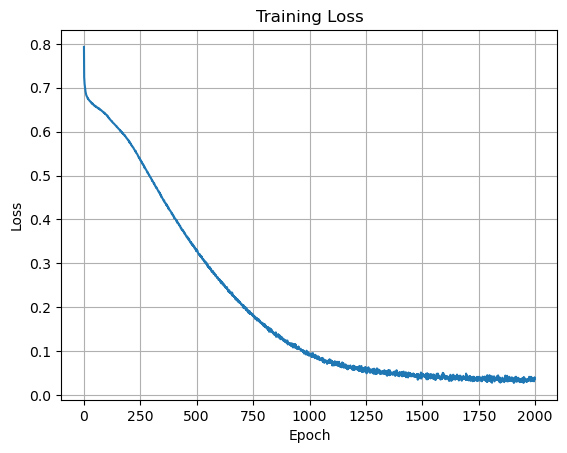

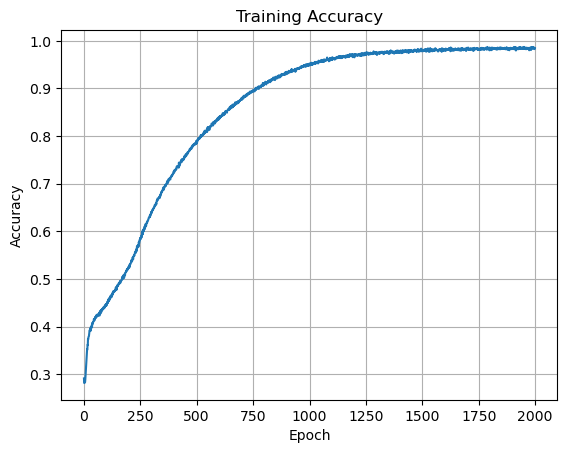

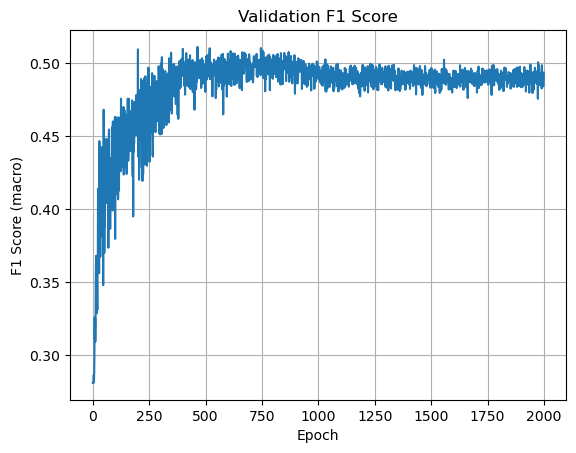

In [33]:
epochs = history["epoch"]

plt.figure()
plt.plot(epochs, history["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, history["train_f1"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, history["val_f1"])
plt.xlabel("Epoch")
plt.ylabel("F1 Score (macro)")
plt.title("Validation F1 Score")
plt.grid(True)
plt.show()

In [34]:
test_dataset = GANTableDataset(cond_df[36000:], s_scaled[36000*50:])

In [35]:
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)

In [36]:
def predict(model, dataloader, device, best_state=None):
    """
    Returns:
        preds: numpy array of predicted class indices
        targets: numpy array of true class indices
    """

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for s, c, y in dataloader:
            s = s.to(device)
            c = c.to(device)
            y = y.to(device)

            logits = model(s, c)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    return all_preds, all_targets

In [37]:
y_pred, y_true = predict(model, test_loader, device)

In [38]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("Test F1 (macro):", f1_score(y_true, y_pred, average="macro"))

print(classification_report(y_true, y_pred))

Test Accuracy: 0.6794166666666667
Test F1 (macro): 0.42577877691745813
              precision    recall  f1-score   support

           0       0.22      0.25      0.23      1290
           1       0.82      0.80      0.81      9444
           2       0.23      0.24      0.24      1266

    accuracy                           0.68     12000
   macro avg       0.42      0.43      0.43     12000
weighted avg       0.69      0.68      0.68     12000

